# Basic Autoencoder

## Imports and definitions

### Model Class and Loss Function Definitions

In [1]:
# %load sconce/models/basic_autoencoder.py
from torch import nn
from torch.nn import functional as F
from sconce.models.layers import FullyConnectedLayer


class BasicAutoencoder(nn.Module):
    """
    A basic 2D image autoencoder built up of fully connected layers, three each in the encoder and the decoder.

    Loss:
        This model uses binary cross-entropy for the loss.

    Metrics:
        None

    Arguments:
        image_height (int): image height in pixels.
        image_width (int): image width in pixels.
        hidden_size (int): the number of activations in each of the 4 hidden layers.
        latent_size (int): the number of activations in the latent representation (encoder output).
    """
    def __init__(self, image_height, image_width, hidden_size, latent_size):
        super().__init__()
        self.num_pixels = image_height * image_width


        self.fc1 = FullyConnectedLayer(in_size=self.num_pixels,
                out_size=hidden_size,
                activation=nn.ReLU())

        self.fc2 = FullyConnectedLayer(in_size=hidden_size,
                out_size=hidden_size,
                activation=nn.ReLU())

        self.fc3 = FullyConnectedLayer(in_size=hidden_size,
                out_size=latent_size,
                activation=nn.ReLU())

        self.fc4 = FullyConnectedLayer(in_size=latent_size,
                out_size=hidden_size,
                activation=nn.ReLU())

        self.fc5 = FullyConnectedLayer(in_size=hidden_size,
                out_size=hidden_size,
                activation=nn.ReLU())

        self.fc6 = FullyConnectedLayer(in_size=hidden_size,
                out_size=self.num_pixels,
                activation=nn.Sigmoid())

    def encode(self, inputs, **kwargs):
        encoder_input = inputs.view(-1, self.num_pixels)
        x = self.fc1(encoder_input)
        x = self.fc2(x)
        x_latent = self.fc3(x)
        return x_latent

    def decode(self, x_latent):
        x = self.fc4(x_latent)
        x = self.fc5(x)
        outputs = self.fc6(x)
        return outputs

    def forward(self, inputs, **kwargs):
        x_latent = self.encode(inputs)
        outputs = self.decode(x_latent)
        return {'outputs': outputs}

    def calculate_loss(self, inputs, outputs, **kwargs):
        reconstruction_loss = F.binary_cross_entropy(outputs,
                inputs.view_as(outputs))
        return {'loss': reconstruction_loss}


## DataGenerators

In [2]:
from sconce.data_generators import ImageDataGenerator

kwargs = {
    'batch_size': 500,
    'num_workers': 2,
    'pin_memory': True,
    'shuffle': True
}

training_generator = ImageDataGenerator.from_torchvision(**kwargs)
test_generator = ImageDataGenerator.from_torchvision(train=False, **kwargs)

## Trainer

In [3]:
import torch
from torch import optim
from sconce.trainers import AutoencoderTrainer

def get_trainer(hidden_size, latent_size, momentum=0.9, weight_decay=1e-4):
    model = BasicAutoencoder(image_width=28, image_height=28,
                hidden_size=hidden_size, latent_size=latent_size)
    
    if torch.cuda.is_available():
        model.cuda()
        training_generator.cuda()
        test_generator.cuda()
        
    optimizer = optim.SGD(model.parameters(), lr=1e-4, momentum=0.9, weight_decay=1e-4)
    trainer = AutoencoderTrainer(model=model, optimizer=optimizer,
        training_data_generator=training_generator,
        test_data_generator=test_generator)
    return trainer

## Results

### Constricted Bottleneck

In [4]:
trainer = get_trainer(hidden_size=40, latent_size=2)

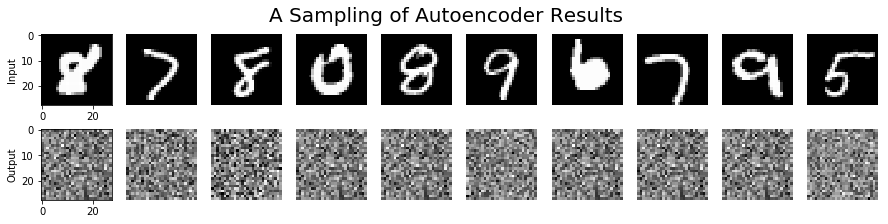

In [5]:
trainer.plot_input_output_pairs();

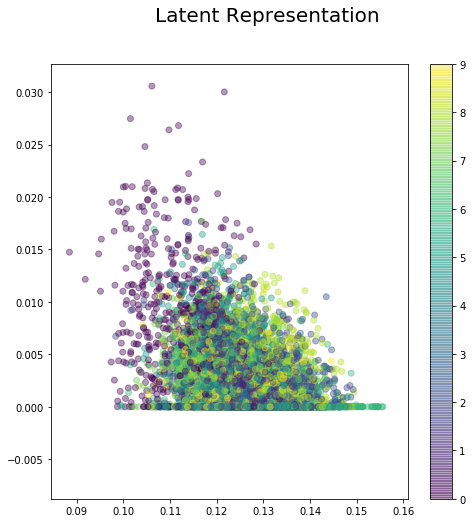

In [6]:
trainer.plot_latent_space();

210/240 [=========================>....] - ETA: 0s - loss: 0.3871

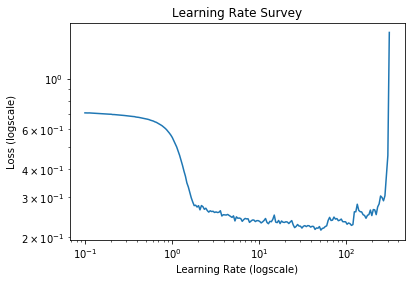

In [7]:
survey_monitor = trainer.survey_learning_rate(
    num_epochs=2, 
    min_learning_rate=1e-1,
    max_learning_rate=1e3,
    stop_factor=3)
survey_monitor.dataframe_monitor.plot_learning_rate_survey()

In [8]:
from sconce.rate_controllers import TriangleRateController
rate_controller = TriangleRateController(
    max_learning_rate=10, min_learning_rate=1)
trainer.train(num_epochs=5, rate_controller=rate_controller)

600/600 [==============================] - 8s 14ms/step - loss: 0.2409 - val_loss: 0.2441


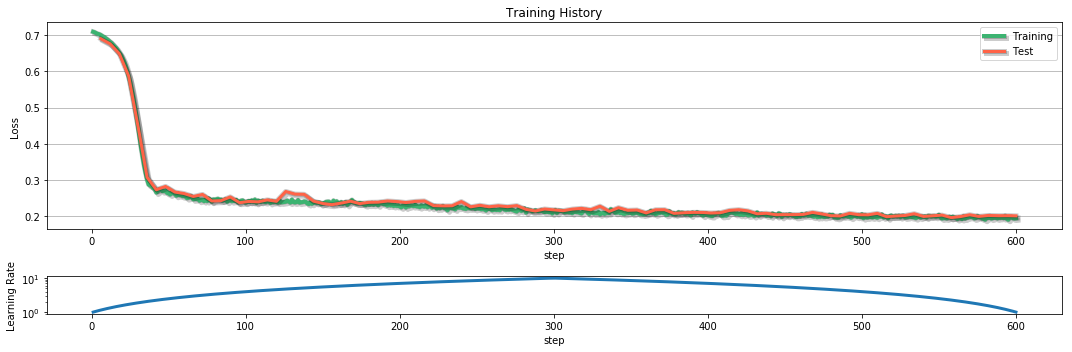

In [9]:
trainer.monitor.dataframe_monitor.plot(smooth_window=1, skip_first=0);

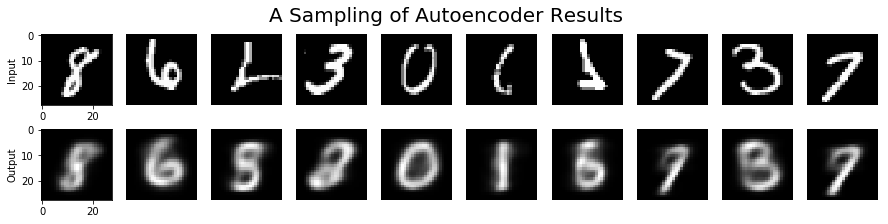

In [10]:
trainer.plot_input_output_pairs();

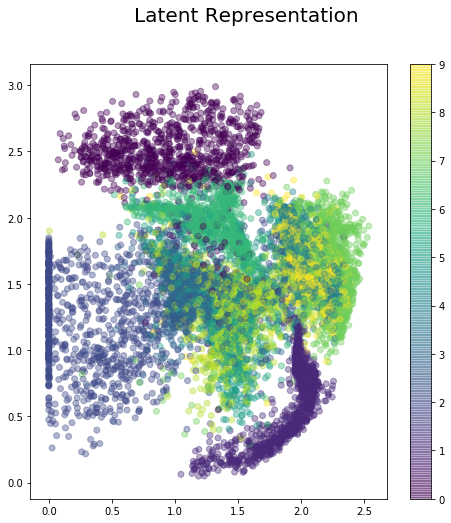

In [11]:
trainer.plot_latent_space();

In [12]:
test_monitor = trainer.test()
test_loss = test_monitor.dataframe_monitor.df['test_loss'].mean()
print(f'Final Test Loss: {test_loss: 0.3e}')
print(f'Number of trainable parameters: {trainer.num_trainable_parameters}')

120/120 [==============================] - 2s 14ms/step - loss: 0.1986
Final Test Loss:  1.986e-01
Number of trainable parameters: 68918


### Relaxed Bottleneck

In [13]:
def train_simple_ae(hidden_size, latent_size):
    trainer = get_trainer(hidden_size=hidden_size, latent_size=latent_size)
    trainer.train(num_epochs=5, rate_controller=rate_controller)
    test_monitor = trainer.test()
    test_loss = test_monitor.dataframe_monitor.df['test_loss'].mean()
    print(f'Final Test Loss: {test_loss: 0.3e}')
    print(f'Number of trainable parameters: {trainer.num_trainable_parameters}')
    trainer.monitor.dataframe_monitor.plot(smooth_window=1, skip_first=0)
    trainer.plot_input_output_pairs()

120/120 [==============================] - 2s 14ms/step - loss: 0.1263
Final Test Loss:  1.263e-01
Number of trainable parameters: 70412


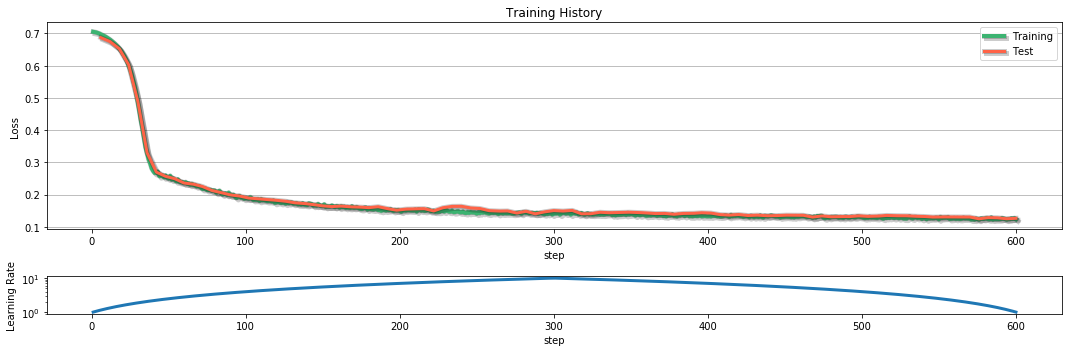

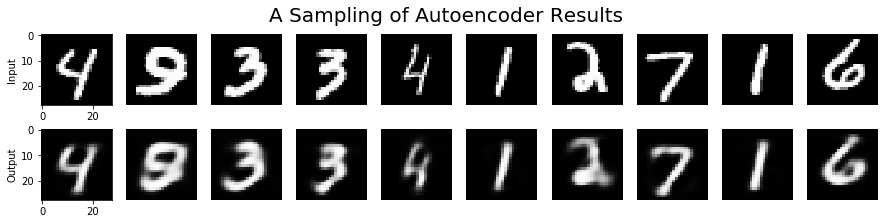

In [14]:
train_simple_ae(hidden_size=40, latent_size=20)

120/120 [==============================] - 2s 15ms/step - loss: 0.1261
Final Test Loss:  1.261e-01
Number of trainable parameters: 72072


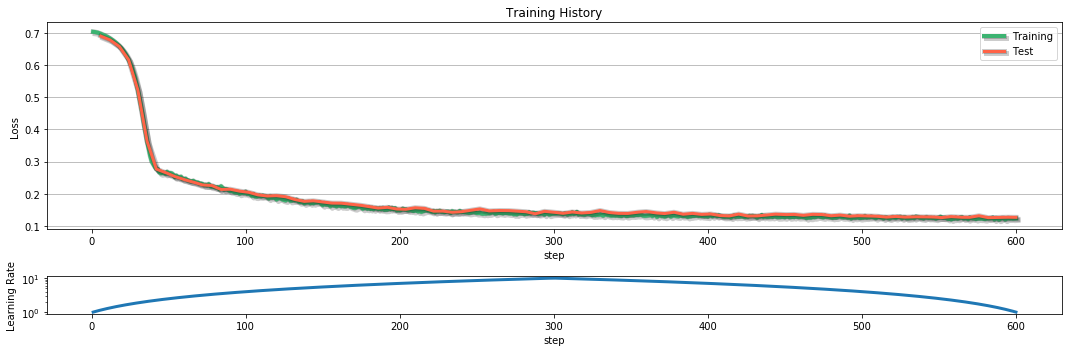

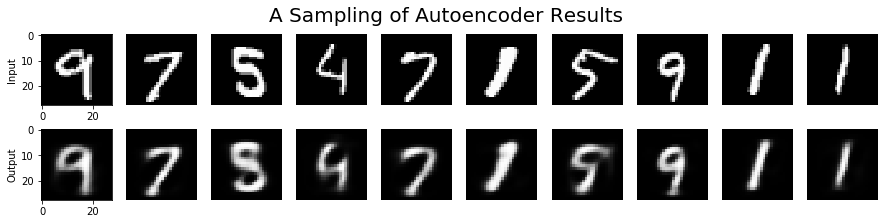

In [15]:
train_simple_ae(hidden_size=40, latent_size=40)